# Preamble

In [1]:
from sympy import init_session
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_styles import analytic
import numpy as npy
import scipy as sp
from scipy.optimize import brentq
%matplotlib widget
import os, glob, pathlib
from loky import get_reusable_executor
import dill as pickle
from sympy.utilities.lambdify import lambdastr
import subprocess
init_session()
def save_to_clipboard(dpi=300):
    plt.savefig("/tmp/clipboard.png", format="png", bbox_inches="tight", dpi=dpi)
    subprocess.run(
        [
            "osascript",
            "-e",
            f'set the clipboard to (read (POSIX file "/tmp/clipboard.png") as «class PNGf»)',
        ]
    )
init_session()

IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/

IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [2]:
EXPRS = {}

In [3]:
def term_simplify(expr):
    run = 0
    for arg in expr.args:
        run += arg.simplify()
    return(run)

def term_multiply(expr, mult):
    run = 0
    for term in expr.args:
        run += term*mult
    term_simplify(run)
    return(run)

In [4]:
# Positive constant
G, M, mp, ep, b, bp, j, mup, tm, b1_3_2, b2_3_2 = symbols("G M m_p e_p beta beta_p j mu_p tau_m b_{3/2}^{(1)}(\\alpha_0) b_{3/2}^{(2)}(\\alpha_0)", positive=True)
# Precession frequencies
om, omp = symbols("omega omega_p")
# Functions of time
lp, np, l, pom, th, thp = symbols("lambda_p n_p lambda varpi theta theta_p") 
ap, a, alpha = symbols("a_p a alpha", positive=True)
# Positive functions of time
e = symbols("e", positive=True)
# Actions
Gam, Lam = symbols("Gamma Lambda", positive=True)
# Derivatives
dth, dthp = symbols(r"\dot\theta \dot\theta_p")

In [5]:
EXPRS[thp] =  (j + 1) * l - j * lp - omp * t
EXPRS[th] = (j + 1) * l - j * lp - pom

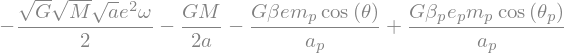

In [6]:
H_expr = - G*M/(2*a) - Rational(1,2)*sqrt(G*M*a)*e**2*om + G*mp/ap*bp*ep*cos(thp) - G*mp/ap*b*e*cos(th)
H_expr

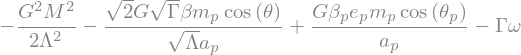

In [7]:
H = H_expr.subs(
    {
        Rational(1, 2) * sqrt(G * M * a) * e**2: Gam,
        e: sqrt(2 * Gam / Lam),
        a: Lam**2 / (G * M),
    }
)
H = term_simplify(H)
H

In [8]:
def diff(expr, var):
    run = expr.diff(var)
    for key in EXPRS.keys():
        run += expr.diff(key)*EXPRS[key].diff(var)
    return(run)

Right now, keeping ALL terms, and removing $\mathcal O(\mu_p^2)$ in the Latex document

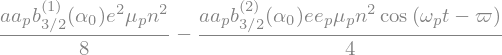

In [9]:
R = mup*n**2*a**2*Rational(1,8)*(ap/a)*b1_3_2*e**2 - mup*n**2*a**2*Rational(1,4)*(ap/a)*b2_3_2*e*ep*cos(omp*t-pom)
R

## Physical sources of apsidal precession

In [10]:
MUJUP = 9.55e-4
MUURN = 4.366e-5
MUSAT = 2.858e-4
SMAJUP = 5.20
SMAURN = 9.54
SMASAT = 19.19
def nep_omp_np(smaext, muext):
    SMANEP = 30.07
    return 0.75 * muext * (smaext / SMANEP) ** 2
alpha0val = (2 / (2 + 1)) ** (2.0 / 3)
0.75*(1-alpha0val**3.5)
DPOM_GPS = (nep_omp_np(SMAJUP,MUJUP)+nep_omp_np(SMASAT,MUSAT)+nep_omp_np(SMAURN,MUURN))*(1-alpha0val**(3.5))
DPOM_GPS

# EOMs

## $\dot \Lambda$

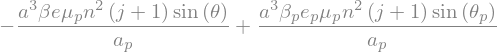

In [11]:
Lamdot = (
    -diff(H, l)
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
Lamdot

## $\dot n$

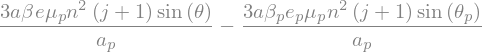

In [12]:
ndot = term_multiply(Lamdot, -3 * n**2 * a / (G * M))
ndot = (
    ndot.subs({sqrt(2 * Gam / Lam): e})
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
ndot

## $\dot a$

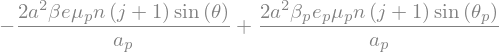

In [13]:
adot = term_multiply(Lamdot, 2/(n*a))
adot

## $\dot \Gamma$

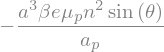

In [14]:
Gamdot = (
    diff(H, pom)
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
Gamdot

## $\dot e$

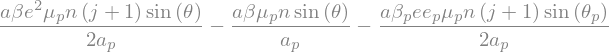

In [15]:
edot = Gamdot/(Lam*e) - term_multiply(Lamdot, Rational(1,2)/Lam*e)
edot = edot.subs({sqrt(2*Gam/Lam):e})
edot = edot.subs({Lam:sqrt(G*M*a)}).subs({sqrt(G*M):n*a**Rational(3,2)})
edot

## $\dot \varpi$

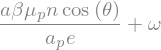

In [16]:
pomdot = (
    (-diff(H, Gam))
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
pomdot

## $\dot \lambda$

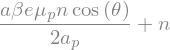

In [17]:
ldot = (
    diff(H, Lam)
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)

ldot

## $\dot \theta_p$

## $\ddot\lambda$

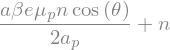

In [18]:
ldot

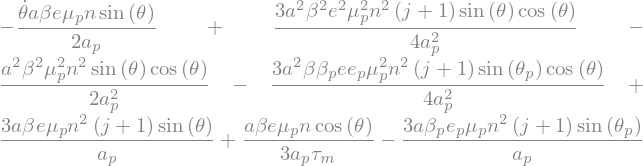

In [19]:
lddot = (
    (
        diff(ldot, th) * dth 
        +term_multiply(adot,diff(ldot, a))
        +term_multiply(edot,diff(ldot, e))
        +term_multiply(ndot,diff(ldot, n).args[0])
        +term_multiply(ndot,diff(ldot, n).args[1])
        +diff(ldot,ap)*(-2*ap/(3*tm))
    )
) 
lddot

In [20]:
#lddot = (lddot + O(mup**2)).removeO() # first order in mu_p since theres not 1/e terms
#lddot

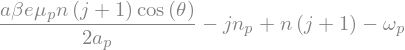

In [21]:
thpdot = term_multiply(ldot,(j+1)) - j*np - omp
thpdot

In [22]:
print(latex(thpdot))

\frac{a \beta e \mu_{p} n \left(j + 1\right) \cos{\left(\theta \right)}}{2 a_{p}} - j n_{p} + n \left(j + 1\right) - \omega_{p}


## $\ddot\theta_p$

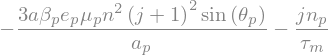

In [23]:
thpddot = term_multiply(lddot,(j+1)) - j*np/tm
thpddot.subs(b,0)

In [24]:
print(latex(thpddot.subs(a/ap,alpha**(-1))))

- \frac{\dot\theta \beta e \mu_{p} n \left(j + 1\right) \sin{\left(\theta \right)}}{2 \alpha} - \frac{j n_{p}}{\tau_{m}} + \frac{3 \beta e \mu_{p} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta \right)}}{\alpha} + \frac{\beta e \mu_{p} n \left(j + 1\right) \cos{\left(\theta \right)}}{3 \alpha \tau_{m}} - \frac{3 \beta_{p} e_{p} \mu_{p} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta_{p} \right)}}{\alpha} + \frac{3 \beta^{2} e^{2} \mu_{p}^{2} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta \right)} \cos{\left(\theta \right)}}{4 \alpha^{2}} - \frac{\beta^{2} \mu_{p}^{2} n^{2} \left(j + 1\right) \sin{\left(\theta \right)} \cos{\left(\theta \right)}}{2 \alpha^{2}} - \frac{3 \beta \beta_{p} e e_{p} \mu_{p}^{2} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta_{p} \right)} \cos{\left(\theta \right)}}{4 \alpha^{2}}


## $\dot\varpi_{\rm sec}$

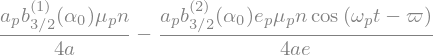

In [25]:
pomdsec = term_multiply(diff(R,e),1/(n*a**2*e))
pomdsec

## $\dot e_{\rm sec}$

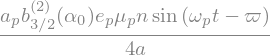

In [26]:
edsec = -diff(R,pom)/(n*a**2*e)
edsec